
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is yellow line
* Saves Results to text file



## Experimental Details


In [7]:

Exp_detail = "GPT:"



## Libraries


In [8]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [9]:

import pandas as pd
import numpy as np


In [10]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [11]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [12]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [13]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [14]:

from einops import rearrange
from math import sqrt, log


In [15]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [16]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [17]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [18]:

device = "cpu"


In [19]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [20]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [21]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [22]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [23]:

pos_emb.shape


torch.Size([15, 512])

In [24]:

res = x_enc + pos_emb


In [25]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [26]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [27]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [28]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [29]:

for_RNN_data_CIVS


,Unnamed: 0,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,1,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,2,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,3,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,4,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,5,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1379,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,1380,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,1381,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,1382,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [30]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [31]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [32]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [33]:

for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Plots


In [34]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

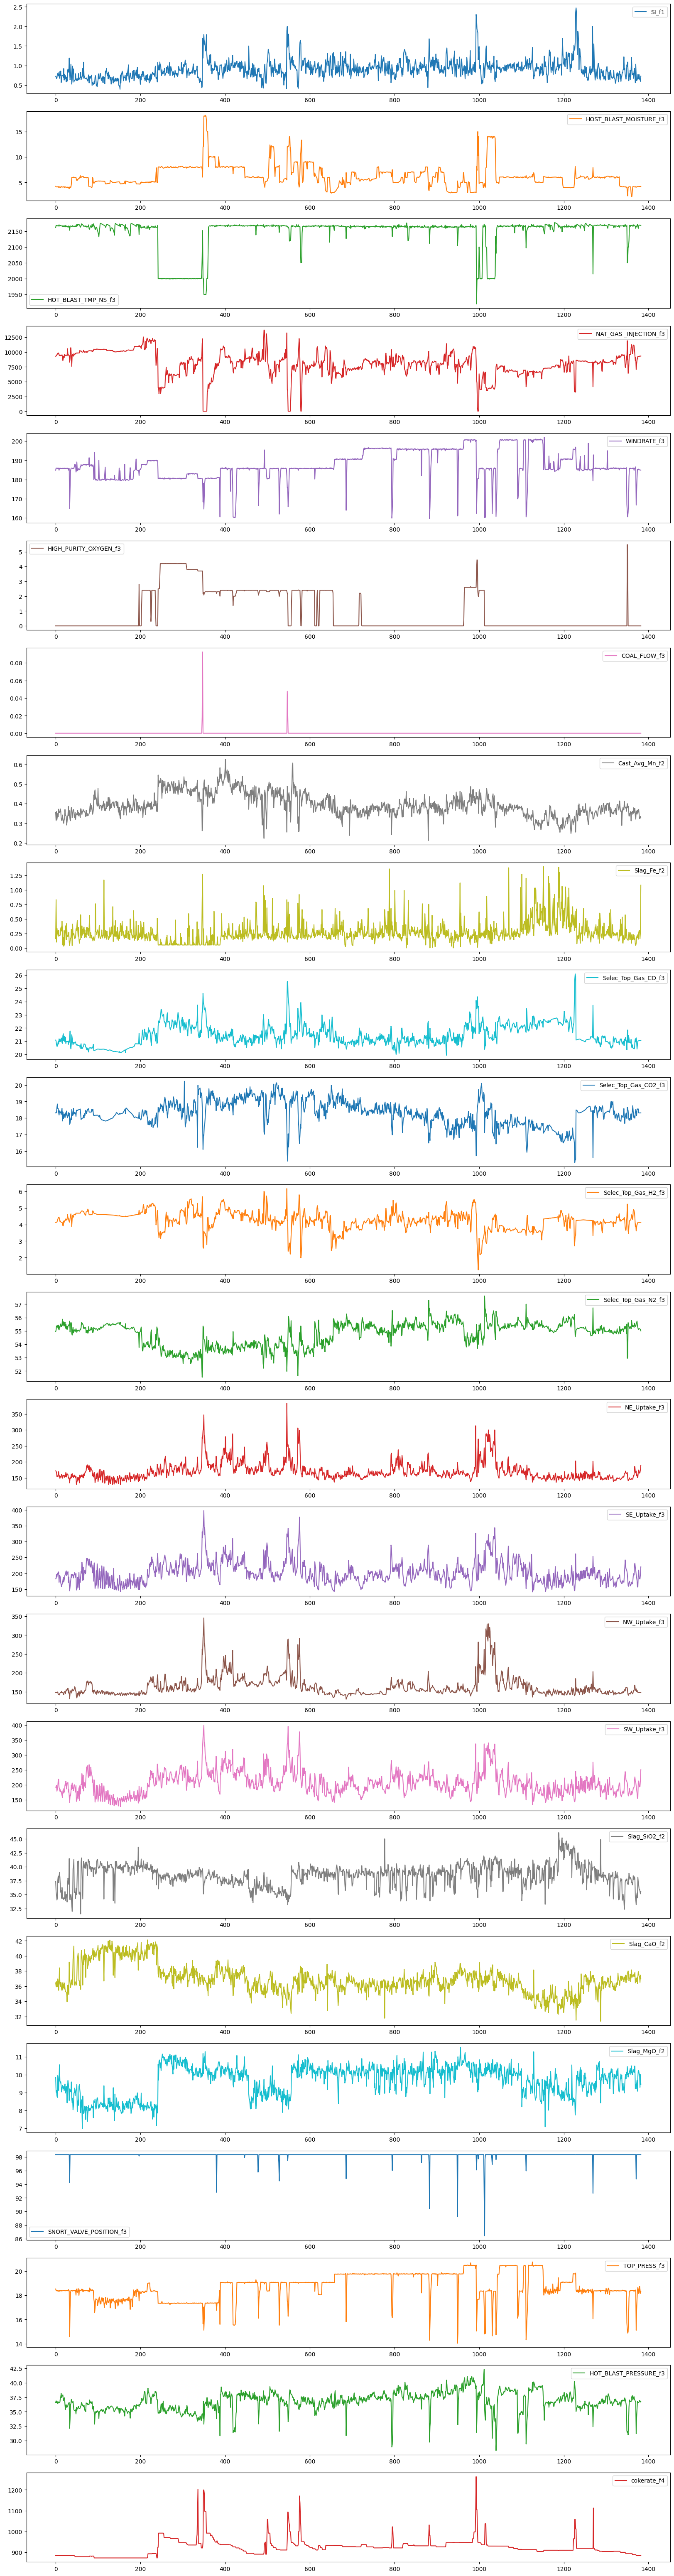

In [35]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [36]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [37]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [38]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [39]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [40]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    ## ix = [ int( tensor1.item() ) for tensor1 in ix ]
    ## print(ix.shape)
    ## print(ix)
    ## print(ix[1])
    ## print(  type(ix[1])  )
    ## print( len(data_gpt) - block_size )
    ## print(  block_size )
    ## print(  (batch_size,)  )
    
    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [41]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [42]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [43]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        ## perform weighted aggregation of values
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [44]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [45]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [46]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [47]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x


In [48]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size= output_size
        self.seq_length = seq_length
        self.input_size = input_size

        
        ## self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # rc remove
        self.map_act    = nn.ReLU()

        self.map_permute1 = nn.Linear( 512, 512 )
        self.map_permute2 = nn.Linear( 512, 512  )
        self.act_permute1 = nn.ReLU()
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )

        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = idx - res

        #####################

        B = idx.shape[0]       ## 8
        T = idx.shape[1]       ## 20
        
        ## B, T = idx.shape     ## (Batch, 40)
        ## ids and targets are both (B, T) tensors of integers
        ## tok_emb = self.token_embedding_table(idx)  

        idx = self.map_24_512( idx )
        idx = self.map_act(    idx )

        tok_emb = idx       ## (8, 15, 512)
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sins and cosines

        ## print("blue")
        ## print(tok_emb.shape)
        ## print(pos_emb.shape)
        
        x = tok_emb + pos_emb    ## [B, T, E] or [64, 40, 512], now [8, 20, 24]

        ## self.map_24_512 = nn.Linear(24, 512)  ## [24, 512] # rc remove
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65] 
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            print(idx_cond.shape)
            logits = self(idx_cond, 0 )    ## ## get preds
            print("logits")
            print(logits.shape)
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            print(logits.shape)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            print("concat added the new pred")
            print(idx.shape)
            
        return idx
            


In [49]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )
    ## optimizer    = torch.optim.RMSprop(  model.parameters(), lr=learning_rate   )

    ## criterion       = nn.MSELoss()
    criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}

    ## train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )
    
    train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        ## xb, yb = get_batch('train')
        xb, yb    = get_batch( train_CIVS_tr_scaled )

        ## rc

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E)
        y_train        = yb.view(B*T, E)

        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        ## loss = criterion( pred[:, 0], y_train[:, 0]  ) 
        
        optimizer.zero_grad(set_to_none=True)           ## zero out
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [50]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ## 20     ## 4          ## 40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 600   ## 5000
eval_interval     = 500     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512   ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2



## Utility Functions


In [51]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()

    x_time_series = test_data

    print( x_time_series.shape )

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]   )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [52]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))

'''
def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    d += 1e-12
    return 0.01*(u / d).mean(-1)
'''

def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse = RSE(pred, true)
    ## corr = CORR(pred, true)

    return mae, mse, rmse, mape, mspe, rse      ##, corr


In [53]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )
    
    print(xb_test.shape)
    print(yb_test.shape)

    input_test_x = xb_test[ :,  : 5 ]
    print("input to m.generate")
    print(input_test_x.shape)


    pred_20_seq = model.generate( input_test_x, 14 )

    print("shape of model generated output: ")
    print(pred_20_seq.shape)

    
    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 

    print(index_to_slice)
    find_index = index_to_slice + 395
    SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index:find_index+19, 0]
    print(SI_data.shape)
    print(x_test.shape)
    
    
    print(y_pred_gpt.shape)
    print(y_real_gpt.shape)

    
    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    print( "unscaling" )

    print(y_pred_gpt.shape)
    print(y_real_gpt.shape)

    l_real = y_real_gpt[ :, 0]
    l_pred = y_pred_gpt[ :, 0]

    l_SI_data_real = SI_data

    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    print("these: ")
    print( x_means.shape )
    print( l_pred.shape )
    print( si_standard_dev.shape )
    print( si_mean.shape )
    print( si_standard_dev )
    print( si_mean)
    print( l_pred )
    print(  )

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]

    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()

    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features


    ##################################################
    

    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    print( l_pred )
    
    print("unscale si end")


    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    print( l_pred  )
    print( l_real )

    print( l_pred.shape  )
    print( l_real.shape  )

    
    print( string_feature )
    print(f'Test MSE Loss - SI only: {mse_eval_bins.item():.4f}')
    print(l_real)
    print(l_pred)
    print(l_SI_data_real)
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric( l_pred, l_real )    )
    print( "Testing R**2 - SI only: ", r2_score(  l_real, l_pred ) )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    print( "Testing R**2 - All features: ", 
            r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
            ) 
    )

    #######################################

    x = [ i for i in range(len(l_real)) ] 
    print(len(x))

    l_SI_data_pred = []
    www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3 ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ## l_SI_data_real = np.roll(l_SI_data_real, -1)

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
 
    ##print( l_pred[1:].shape )
    ##print( l_pred[0].shape )
    ## l_pred  = np.concatenate( ( l_pred[1:, ], l_pred[0] ) )
    
    l_pred = np.roll(l_pred, -1)

    

    ## l_SI_data_pred = np.roll(l_SI_data_pred, 0)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    print( train_plot.shape )
    train_real_plot = train_plot[:, 0]
    ## l_real  = np.concatenate( ( train_real_plot[1: ], train_real_plot[:1] ) )
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    ######################################

    x = [ i for i in range(len(l_real)) ] 
    print(len(x))

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 
    print(len(x_delta))

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    fig.tight_layout()
    ax[1].legend(); plt.show()


In [54]:

def function_train_rc(  train_data  ):
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [55]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )


In [56]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [57]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Delta of SI


In [58]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [59]:

delta_for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [60]:

delta_for_RNN_data_CIVS .insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [61]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [62]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [63]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [64]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [65]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [66]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [67]:

delta_for_RNN_data_CIVS


,delta_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [68]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [69]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [70]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [71]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [72]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [73]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.000000,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.000000,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.000000,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.000000,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.000000,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.004444,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.008900,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,-0.037618,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,-0.014340,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [74]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [75]:

training_chunk = 400


In [76]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [77]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


294

In [78]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
294
709


In [79]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [80]:

sliced_chunk_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
294,-0.025059,0.010383,8.033103,1999.814297,8107.424158,180.518905,4.200594,0.0,0.480,0.05,21.654503,18.427087,4.838710,53.567366,188.435791,261.543902,177.231840,263.528472,37.630001,37.959999,10.99,98.334297,17.346651,34.688388,946.0
295,-0.002727,0.006990,8.169246,1999.888848,7833.881943,180.629239,4.199827,0.0,0.465,0.25,21.992314,18.851720,4.728625,53.039774,194.381513,246.656855,175.276353,264.928440,38.720001,36.950001,10.79,98.334297,17.345610,34.536857,946.0
296,0.004050,0.013098,8.171369,1999.903492,8343.366568,180.170197,4.200258,0.0,0.456,0.05,22.124917,18.562175,4.872412,53.056710,188.936199,247.621769,172.050048,251.713074,37.840000,36.380001,10.66,98.334297,17.357006,34.367241,946.0
297,0.192916,0.027645,8.162566,1999.654967,8250.209166,180.636404,4.200194,0.0,0.500,0.18,22.557425,18.098801,4.910546,53.011599,199.780382,258.767012,190.714892,266.542211,38.540001,37.240002,10.51,98.334297,17.360112,34.082464,946.0
298,-0.278376,0.008181,8.160476,2000.066699,7968.859763,180.296397,4.198162,0.0,0.482,0.06,22.606781,17.918109,4.868437,53.247393,188.090152,246.611707,178.505607,258.214873,37.330002,36.939999,10.70,98.334297,17.363998,34.258766,946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,0.316925,0.040416,7.065582,2163.992759,7065.554737,190.697686,0.000000,0.0,0.379,0.23,20.693986,19.097315,4.073560,54.980104,158.433680,193.529531,144.569960,193.239304,38.790001,37.139999,10.24,98.334297,19.773910,37.753597,927.0
705,-0.191284,0.005738,7.068836,2168.165350,7308.900600,190.388108,0.000000,0.0,0.363,0.20,20.579040,19.031798,4.105431,55.131054,168.995795,190.741429,144.371339,200.730308,38.000000,36.849998,10.19,98.334297,19.776443,38.256911,927.0
706,-0.163103,-0.047804,6.187604,2163.598928,7347.997824,190.761763,0.000000,0.0,0.383,0.15,20.975828,18.425664,4.084254,55.192831,165.161983,183.826703,144.184987,193.166323,38.020000,36.720001,10.17,98.334297,19.789807,36.996745,927.0
707,0.099408,0.024160,6.854342,2163.940340,7057.784805,190.469380,0.000000,0.0,0.391,0.29,21.039993,18.405077,4.182016,55.107410,161.315684,187.869295,143.941916,202.431023,38.230000,35.950001,9.93,98.334297,19.756129,37.286602,927.0



## Train and test


In [81]:

n = block_size

print( n )


15


In [82]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [83]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [84]:

test_CIVS 


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
694,-0.102769,-0.029116,4.982354,2161.252589,6834.450096,190.462549,0.0,0.0,0.238,0.25,20.796026,18.847816,3.747831,55.691058,167.818070,211.914296,144.793475,224.244532,38.060001,36.790001,10.08,98.334297,19.763854,36.447708,927.0
695,0.155495,-0.043870,4.918762,2162.285661,7187.959876,190.641074,0.0,0.0,0.353,0.20,20.845952,18.867027,3.712492,55.503543,181.475390,199.527045,145.657833,221.613297,38.299999,36.680000,10.05,98.334297,19.771955,36.760089,927.0
696,0.372315,0.030434,4.555009,2168.003389,7157.012573,190.603827,0.0,0.0,0.420,0.34,20.916699,18.688635,3.777491,55.591220,172.711613,219.696165,146.340289,224.238005,38.540001,36.570000,10.19,98.334297,19.781936,37.239869,927.0
697,-0.620232,-0.037125,4.839798,2157.925984,7110.627542,190.549321,0.0,0.0,0.403,0.19,20.983970,18.649120,3.666980,55.661863,159.158113,180.788635,139.167438,193.442456,38.349998,36.669998,10.08,98.334297,19.773603,37.064092,927.0
698,0.093823,-0.017858,6.407874,2163.070272,7059.230004,190.548102,0.0,0.0,0.352,0.28,21.029582,18.450404,4.017260,55.483101,166.642669,225.018123,145.852110,228.194152,38.099998,36.520000,10.02,98.334297,19.762222,37.509587,927.0
699,0.074668,0.000975,7.032629,2164.992668,6848.868900,190.552083,0.0,0.0,0.358,0.15,20.724312,18.648297,4.118515,55.465410,163.322057,204.526583,145.428402,213.956687,38.549999,37.349998,10.23,98.334297,19.761716,36.789414,927.0
700,0.087166,-0.011689,7.052733,2164.450904,7034.200522,190.579546,0.0,0.0,0.364,0.05,21.011521,18.791524,4.108527,55.268053,168.860617,201.773606,145.318156,212.605623,36.509998,36.650002,9.77,98.334297,19.774752,36.817445,927.0
701,-0.001214,-0.007044,7.066941,2165.422682,7200.378873,190.781922,0.0,0.0,0.390,0.05,21.109530,18.606715,4.167015,55.147106,187.522001,220.517921,145.240286,233.325100,36.759998,36.310001,9.50,98.334297,19.795139,37.052938,927.0
702,-0.055353,-0.010118,7.045488,2163.529183,7215.794245,190.577701,0.0,0.0,0.395,0.04,20.972968,18.743346,4.127299,55.256959,168.133071,219.094941,145.142028,231.344039,37.009998,36.570000,9.78,98.334297,19.763580,37.298318,927.0
703,-0.019435,-0.001554,6.898119,2165.388787,7098.138144,190.513061,0.0,0.0,0.378,0.24,20.999557,18.521085,4.081047,55.120999,155.623696,200.414459,144.862952,206.001533,38.639999,36.730000,10.08,98.334297,19.797642,37.068372,927.0


In [85]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [86]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.8803466558456421
500 train loss =  0.1426905244588852


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


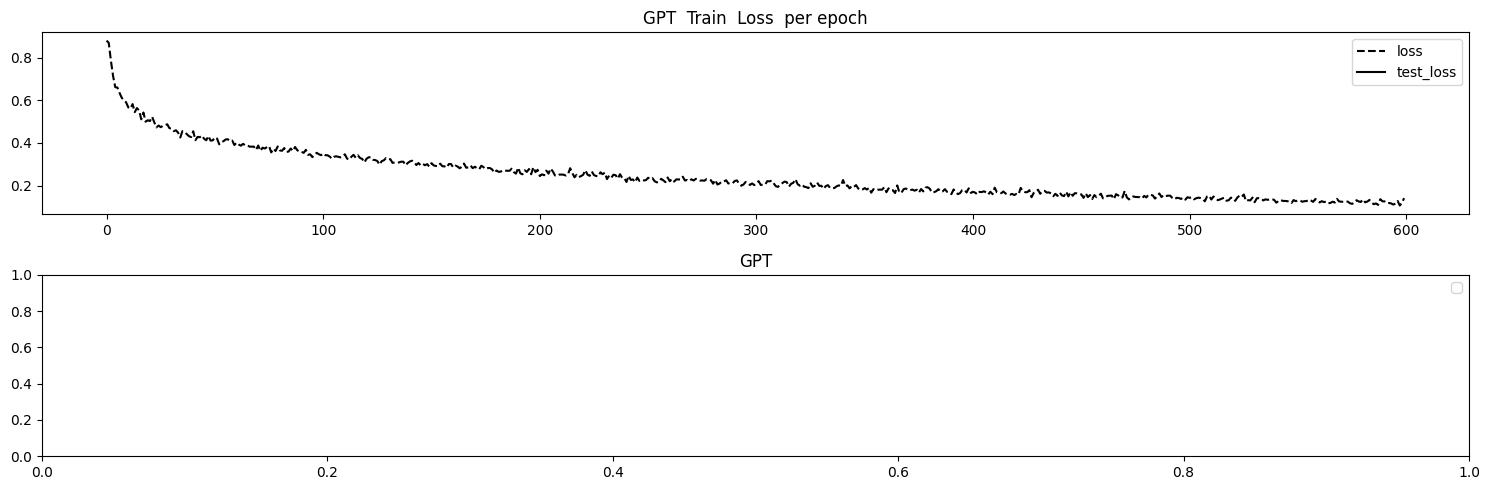

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

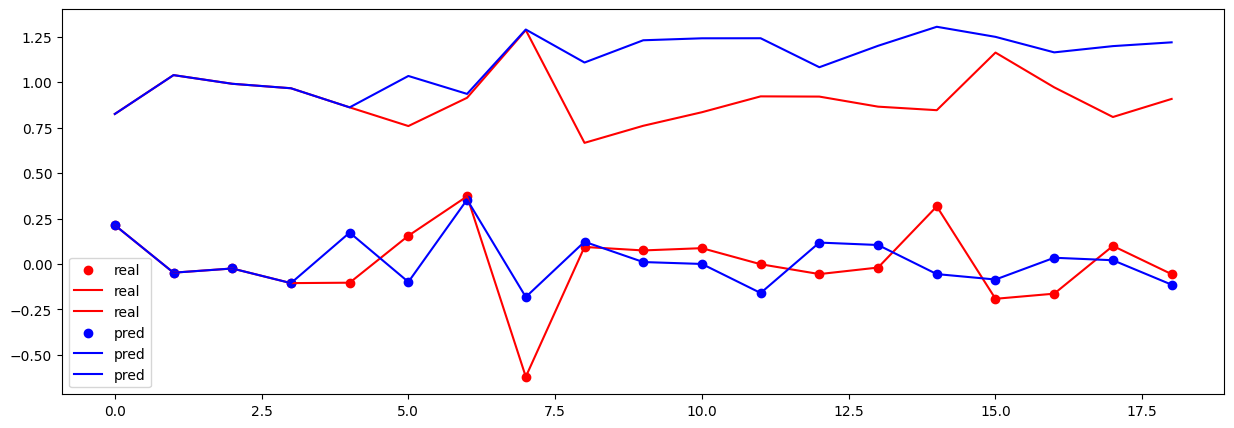

(100, 25)
119
19


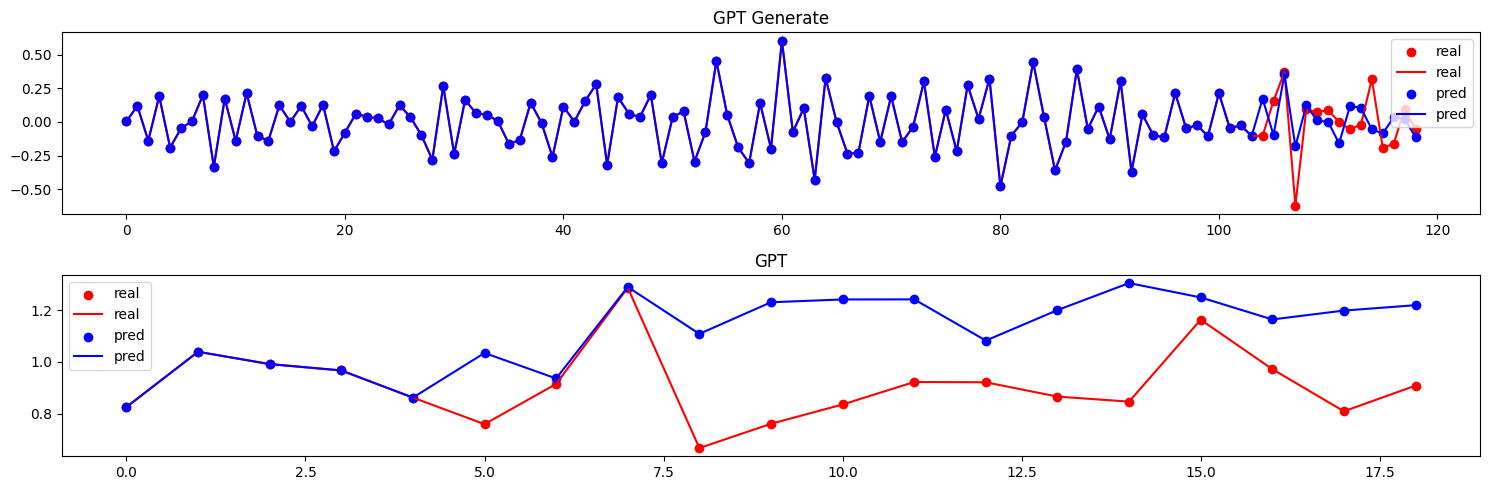

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([200, 25])
0 train loss =  0.8679072260856628
500 train loss =  0.20371785759925842


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


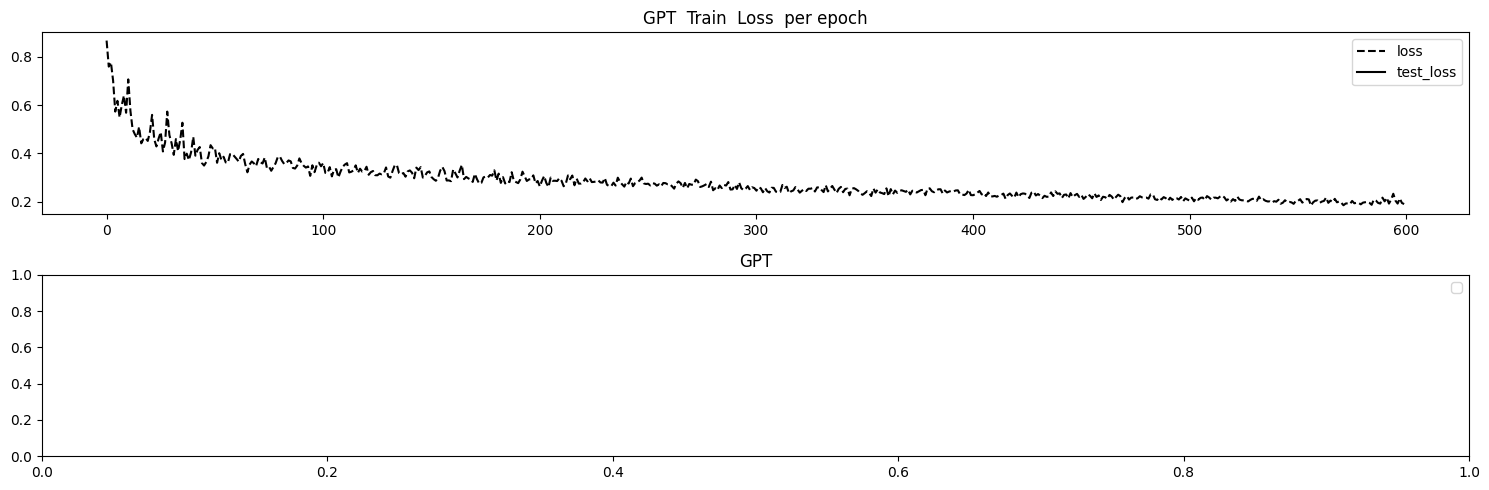

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

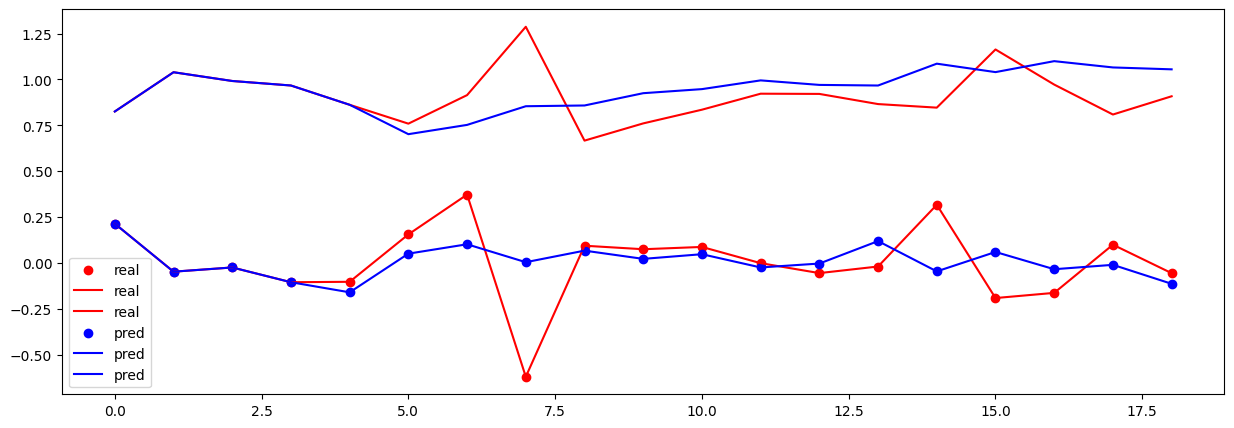

(200, 25)
219
19


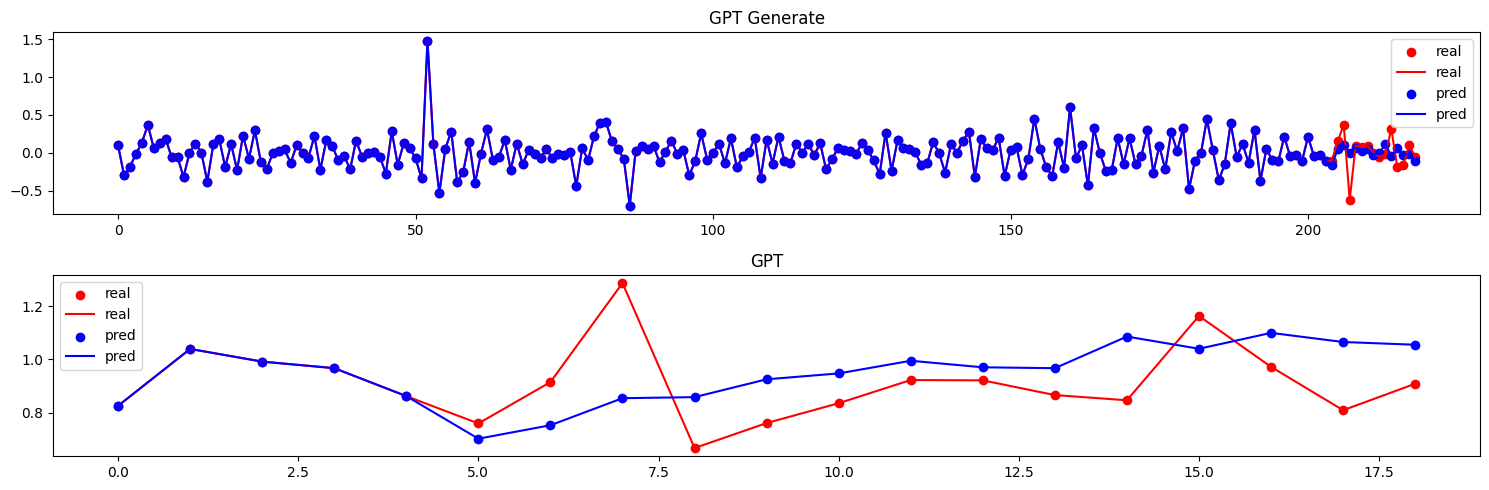

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

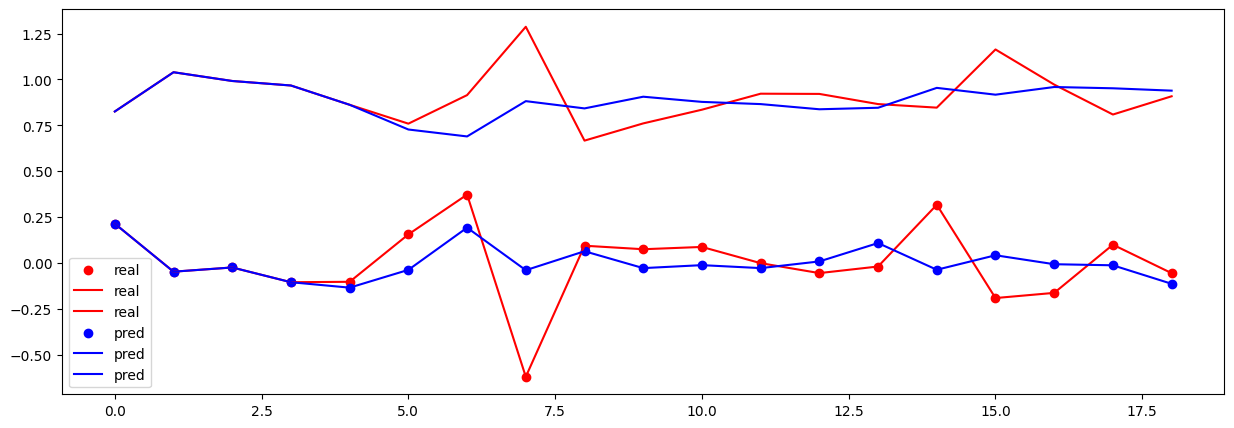

(200, 25)
219
19


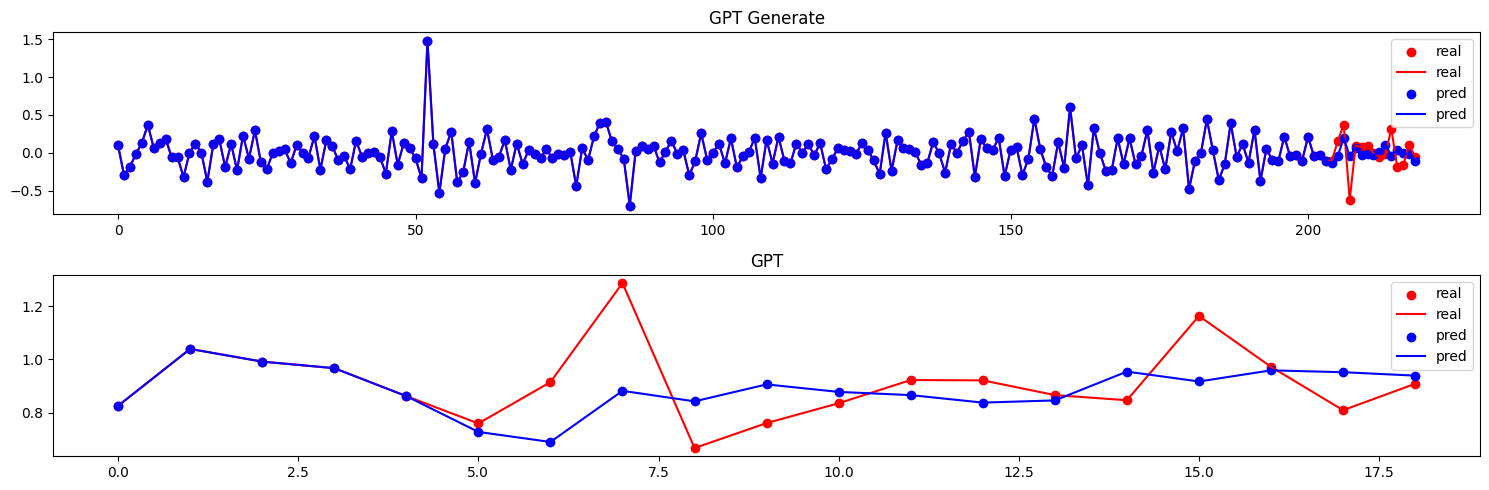

In [89]:

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([300, 25])
0 train loss =  0.9031696915626526
500 train loss =  0.23966984450817108


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


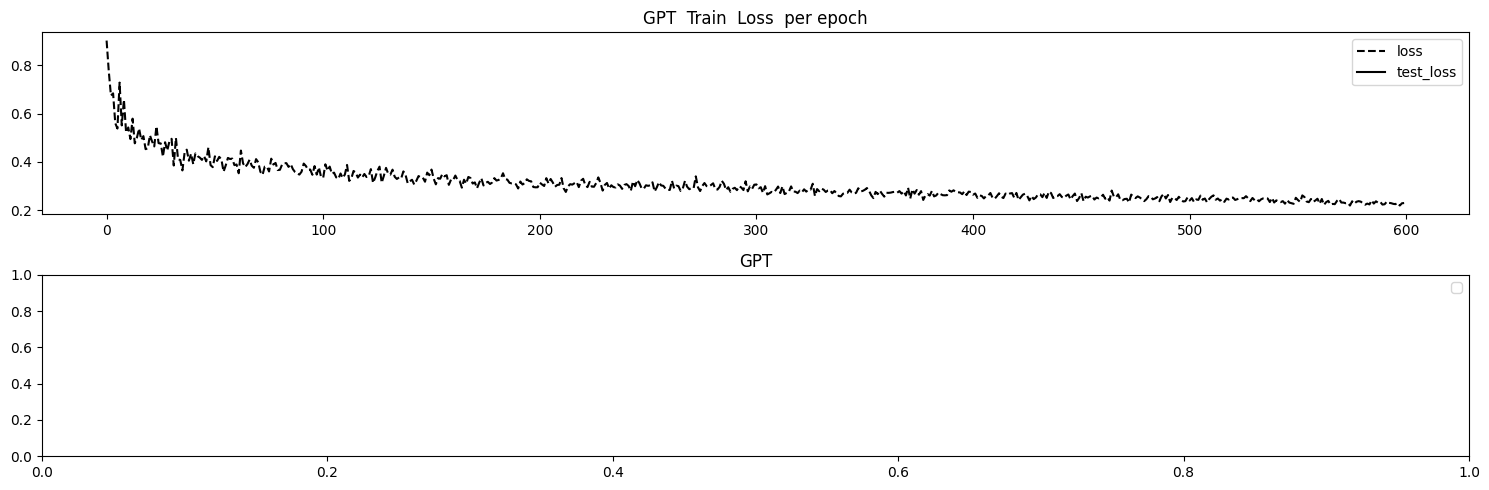

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

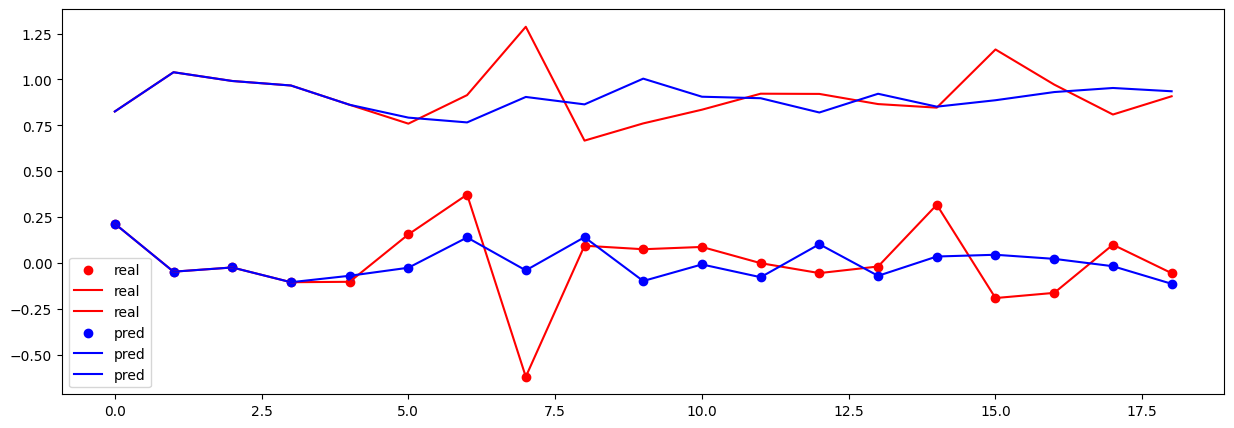

(300, 25)
319
19


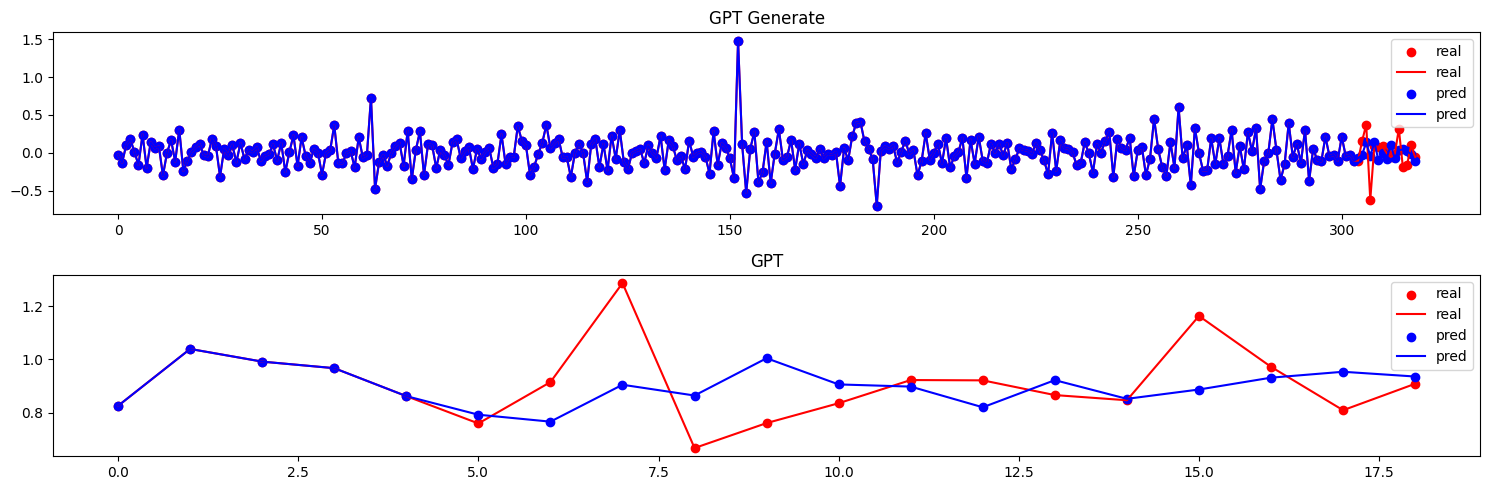

In [90]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.8512831330299377
500 train loss =  0.246796652674675


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


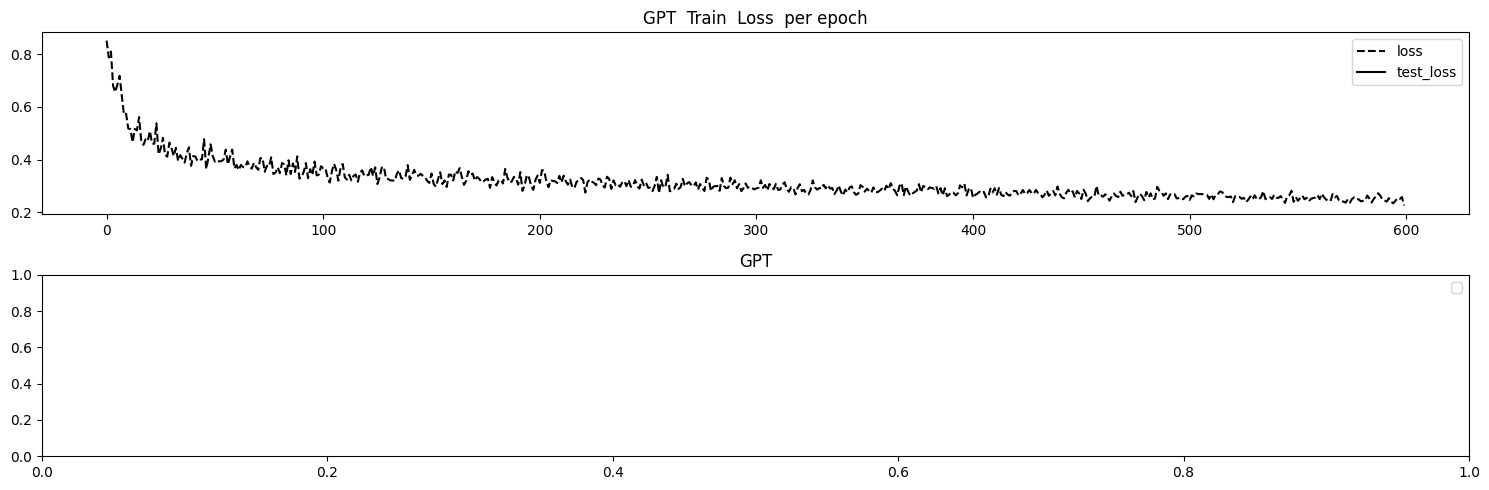

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

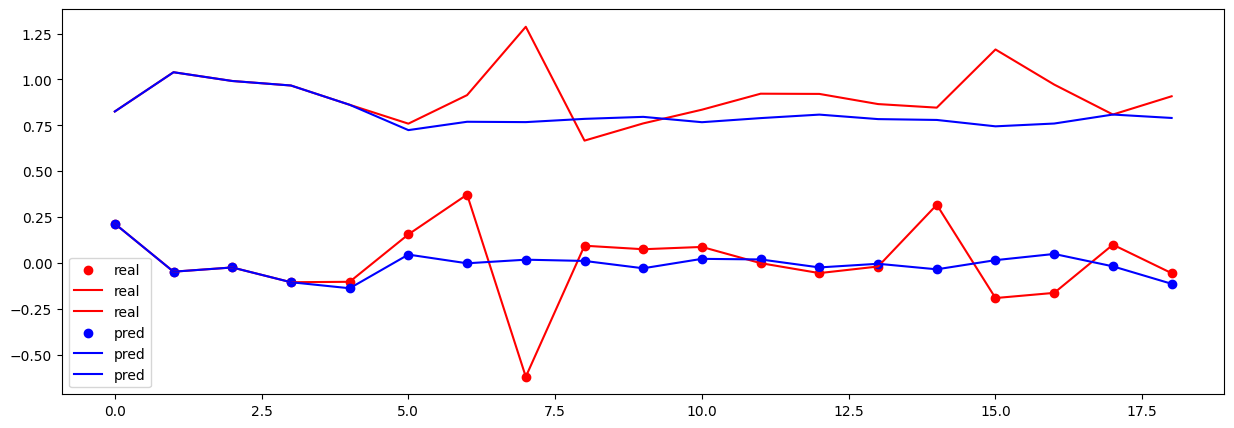

(400, 25)
419
19


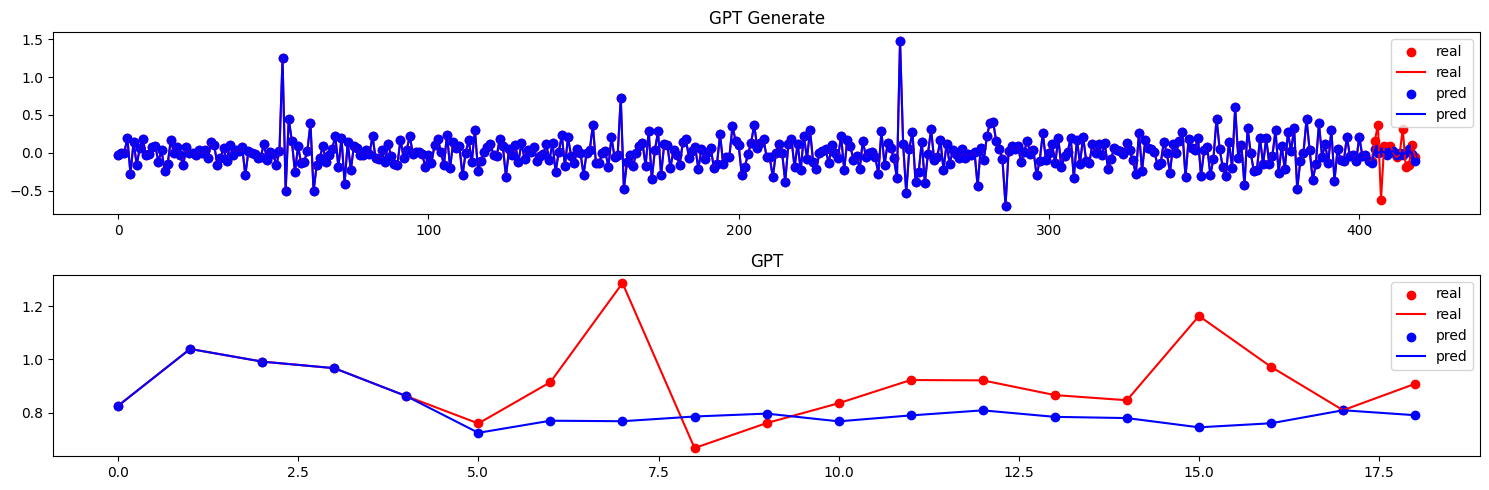

In [91]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 2


In [92]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
173
588
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.910049319267273
500 train loss =  0.14235807955265045


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


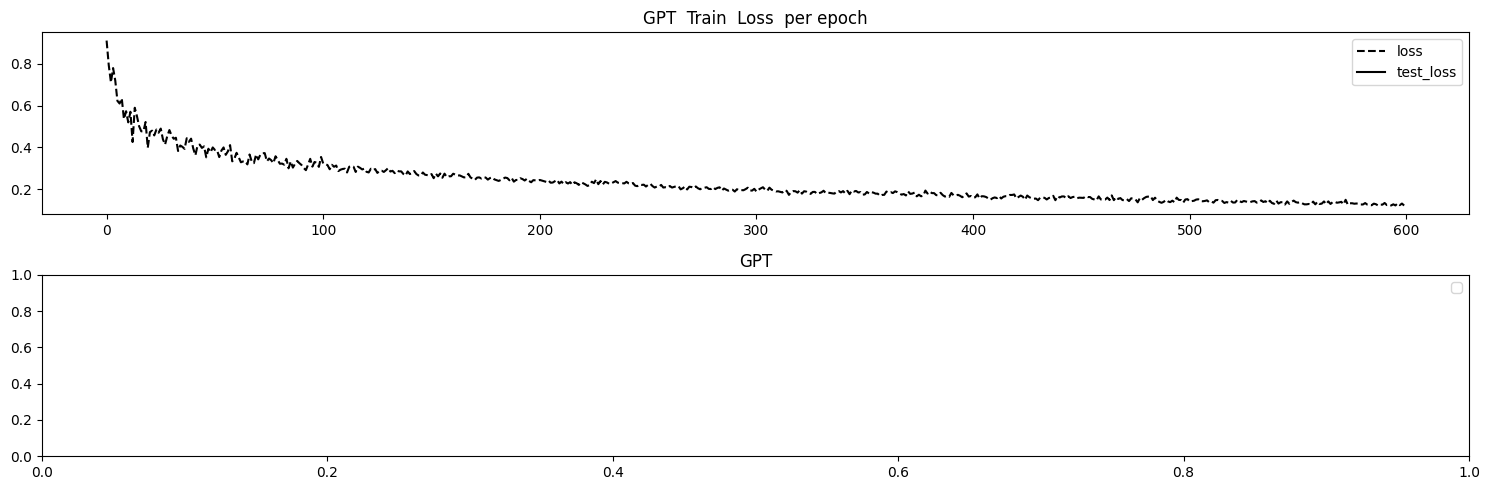

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

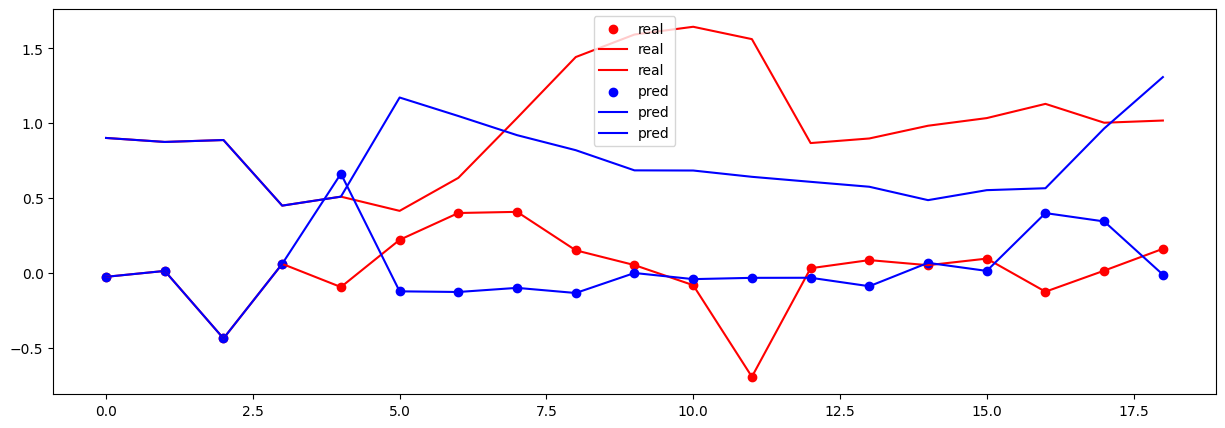

(100, 25)
119
19


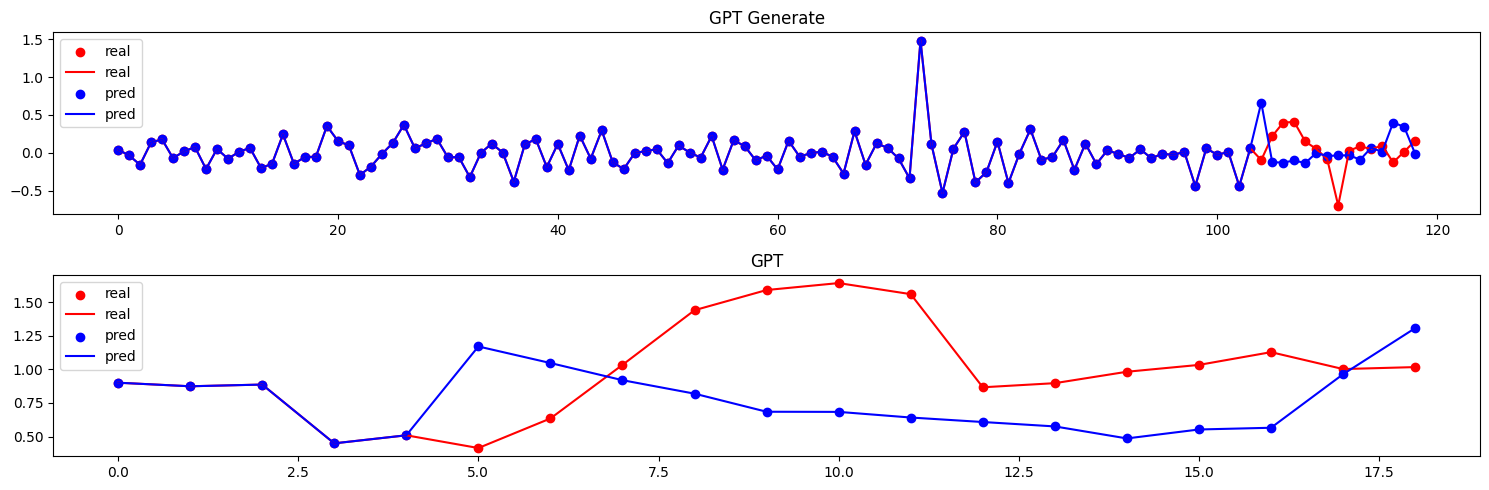

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 3


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 4


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 5


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 6


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )
